Make use of LVector class from HW6 #1. Use that solution!!
solution also includes member functions to rotate vectors in 3D space. 
All masses, momenta, and energies in GeV
given a Decay chain

we want to generate 1,000 such decay chains, starting from $B^+$ at rest. rest fram is lab frame

- $B^+$ is spinless so no preffered direction in space. 
- in sphereical coordinates a random phi is between 0 and 2$\pi$ and $cos\theta$ between -1 and 1. 
- two-body decay: In the rest frame of particle of mass M, decaying into 2 particles labeled 1 and 2
$$E_1=\frac{M^2-m_2^2+m_1^2}{2M}$$
... look more into 48.4 section of http://pdg.lbl.gov/2017/reviews/rpp2017-rev-kinematics.pdf
- dΓ is the particle decay rate

If in $A\rightarrow BC$ the decay angle is defined in the rest frame of A and if A is spinless, which it is the cosine distribution is uniform between -1 and 1. $\rightarrow$ maybe just produce a unform distribution? this has to be created with a randomly generated array of numbers I believe

$D^{*0}$ decay complex has spin of 1. Conservation of angular momentum in the $B^+$ rest frame the $D^{*0}$ has $S_3=0$ where the axis of quantization. the pdf is proportional to the Wigner d-matrix $cos^2\theta_D$  

At the end of the generation you should have a list of 1000 entries, and each entry will be itself a list with five LVectors for teh five final state particles. Vectors should all be in LAB frame. will save these events and write them into a pickle file. look at instructions:

Test that generation makes sense by running decayChain thang 
It should read in the data, check for NRG, p conservation throughout the decay chain, check all decays are back to rest frame, plot the decay angles for all decays, plot momenta of the final state particles. If all good you shoudl see no errors. look at plots brah





In [9]:
# to produce 
import numpy as np
import matplotlib.pyplot as plt

In [10]:
B = np.random.uniform(-1, 1, 1000)

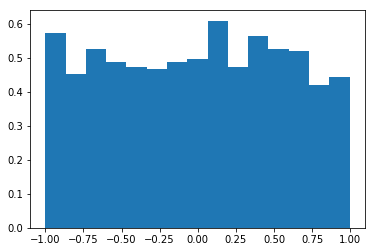

In [16]:
# uniform distribution

count, bins, ignored = plt.hist(B, bins = 15, density = True)
plt.show()

Tricky aspect: axes rotations and boosts

In [18]:
# Monte Carlo generated decay chains?



In [ ]:
## this is the triple decker decay chain checker

#!/usr/bin/env python3
#
# Code to check the pickle output
# file from Homework 8 Exercise 2
#
# CC 4 Mar 2019
#----------------------------
import numpy as np
import ccHistStuff as cc
import LVector as lv
import math
import matplotlib.pyplot as plt
import pickle
import os
import sys

# Masses in GeV
mB     = 5.28
mDstar = 2.01
mD0    = 1.86
mK     = 0.494
mPip   = 0.1396
mPi0   = 0.1350
mg     = 0.0

# Tell the user what masses we will be using for checks
print('Assumes that the events were generated with the following masses')
print('B+    mass  = ', mB)
print('Dstar mass  = ', mDstar)
print('D0    mass  = ', mD0)
print('K-    mass  = ', mK)
print('pi+   mass  = ', mPip)
print('pi0   mass  = ', mPi0)
print('gamma mass  = ', mg)
input('If this is correct continue, otherwise change the masses in the code')

# Read the data from the pickle file
fileName = 'data.pik'
if not os.path.exists(fileName):
    sys.exit('%s does not exist' %fileName)
with open(fileName, 'rb') as f:
    out = pickle.load(f)
print('\n \n Number of events in pickle file = ', len(out))
print(' ')

# The B four vectors in its own rest frame
B = lv.LVector([mB, 0., 0., 0.])

# A tiny number used to check agreement with zero
# within a generous amount of precision 
tiny=1e-5

#------------------ Utility Function ____________________
def getCosTheta(parent, daughter):
    """
    # Returns cosine of decay angle (aka helicity angle)
    # of parent->daughter decay.  The inputs are LVectors
    """
    beta    = parent.get_r()/parent.get_x0()
    betaMag = math.sqrt((beta*beta).sum())
    if betaMag<tiny:    # parent at rest
        return(math.cos(daughter.theta()))
    V = daughter.copy()
    V.boost(beta)
    temp    = V.get_r()*beta
    return temp.sum() / (betaMag * V.get_rlength())

#------------------ Utility Function ____________________
def checkMass(V, m, name, eventNumber):
    thisM = math.sqrt(V.square())
    good = True
    if abs(thisM - m) > tiny:
        print('------------------')
        print('Event ', eventNumber)
        print('Wrong mass for ', name, ' = ',thisM)
        good = False
    return good

#-------------------------------------------------
# Construct the LVectors of the decaying particles
# out of the final state particles.
#
# Check energy momentum conservation
#
# Then extract the decay angles in all 4 decays.
# Make sure that they are back to back
# 
# Finally plot the cos(decayAngle) to make sure that they are OK
#-----------------------------------------------
print('   Checking for consistency...')
cs = []
i = 0
problemEvents = 0
for part in out:
    Ppi1 = (part[0]).copy()
    PK   = (part[1]).copy()
    Ppi2 = (part[2]).copy()
    Pg1  = (part[3]).copy()
    Pg2  = (part[4]).copy()
    
    # composite particles
    d0    = PK    + Ppi2
    pi0   = Pg1   + Pg2
    dstar = d0    + pi0
    Bpl   = dstar + Ppi1

    # check all the masses
    g1 = checkMass(d0,    mD0,    'D0',  i)
    g2 = checkMass(pi0,   mPi0,   'pi0', i)
    g3 = checkMass(dstar, mDstar, 'D*',  i)
    g4 = checkMass(Bpl,   mB,     'B+',  i)
    good = g1 and g2 and g3 and g4
    
    # check overall momentum conservation
    ptot = Bpl.get_rlength()
    if ptot>tiny:
        print('------------------')
        print('Event ', i)
        print('Momentum not conserved P = ', ptot)    
        good = False

    # The various cosines of decay angles (from one particle)
    cs0 = getCosTheta(B,     dstar)    # B   decay
    cs1 = getCosTheta(dstar, pi0)      # D*  decay
    cs2 = getCosTheta(d0,    PK)       # D   decay
    cs3 = getCosTheta(pi0,   Pg1)      # pi0 decay
    cs.append( [cs0, cs1, cs2, cs3] )  # put them in a list for later plotting

    # The various cosines of decay angles (from the other particle)
    cs01  = getCosTheta(B,     Ppi1)    # B   decay
    cs11  = getCosTheta(dstar, d0)      # D*  decay
    cs21  = getCosTheta(d0,    Ppi2)    # D   decay
    cs31  = getCosTheta(pi0,   Pg2)     # pi0 decay

    name = 'none'
    if abs(cs0+cs01) > tiny: name='B'
    if abs(cs1+cs11) > tiny: name='D*'
    if abs(cs2+cs21) > tiny: name='D'
    if abs(cs3+cs31) > tiny: name='pi0'
    if name != 'none':
        print('------------------')
        print('Event ', i)
        print('Decay products not back to back for decay of ', name)
        good = False

    # bump up the problem event counter
    if not good:
        problemEvents = problemEvents + 1    

    # Bump up the event number
    i = i + 1

# How many bad events did we find
print('   Number of events with inconsistencies = ',problemEvents)
print(' ')    
    
# plotting of cosines of the decay angles
csth = np.array(cs)                    # turn list into np.array
f1, a1 = plt.subplots(2,2)
b      = np.linspace(-1,1,21)
a1[0,0].hist(csth[:,0],b,histtype='step')
a1[0,1].hist(csth[:,1],b,histtype='step')
a1[1,0].hist(csth[:,2],b,histtype='step')
a1[1,1].hist(csth[:,3],b,histtype='step')
names = ['cosTheta B-decay', 'cosTheta D*-decay',
        'cosTheta D0-decay', 'cosTheta pi0-decay']
for a,n in zip(a1.reshape(-1),names):
    a.set_xlim(b[0],b[-1])
    a.set_xlabel(n)
plt.tight_layout()
f1.show()
input('Enter something to continue')

#--------------------------------------------------
# Finally, plot the momenta
#--------------------------------------------------
f2, a2 = plt.subplots(2,2)
bb = np.linspace(0.,3.,61)
a2[0,0].hist(  [p[0].get_rlength() for p in out], bb, histtype='step')
a2[0,1].hist(  [p[1].get_rlength() for p in out], bb, histtype='step')
a2[1,0].hist(  [p[2].get_rlength() for p in out], bb, histtype='step')
a2[1,1].hist( [p[3].get_rlength() for p in out] + [p[4].get_rlength() for p in out], bb, histtype='step')
names = ['P 1st pion (GeV)', 'P kaon (GeV)',
        'P 2nd pion (GeV)', 'P gamma (GeV)']
for a,n in zip(a2.reshape(-1),names):
    a.set_xlim(bb[0],bb[-1])
    a.set_xlabel(n)
plt.tight_layout()
f2.show()
input('Enter something to continue')
